
```js
{
    "a": -13.5,
    "dr": -1,
    "v": 0.4,
    "t": -0.2
}
```
a: angle between host and luggage
    angle in degree
    front is 0
    right is positive
dr: distance (relative) between host and luggage
    +1 is getting closer
    0 if distance constant
    -1 if distance getting shorter
d:
    distance between host and luggage

v: velocity of host?
t: direction of the host from the 

Angle in radian
Distance from 0.0 to 1.0 - keep at 0.5

the robot shouldnt move if within 1.5m distance - human can grab it

make reid work?
make simulation to always get the front line of the robot as if following the person at x speed
get north and acceleration

I receive the north to create the map

In [4]:
print('test')

test


In [5]:
names = {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'remote', 66: 'keyboard', 67: 'cell phone', 68: 'microwave', 69: 'oven', 70: 'toaster', 71: 'sink', 72: 'refrigerator', 73: 'book', 74: 'clock', 75: 'vase', 76: 'scissors', 77: 'teddy bear', 78: 'hair drier', 79: 'toothbrush'}

# camera settings
# hfov = 67.0
# wr = 1280

hfov = 59
wr = 1080
hr = 720
avg_shoulder_width = 350.0
avg_torso_height = 460.0


In [6]:
from dataclasses import dataclass
from IPython.display import clear_output

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import numpy as np
import pandas as pd
import cv2
import math
import time
import os
import queue

import torch
from ultralytics import YOLO
import mediapipe as mp



In [134]:
# todo type conversion

@dataclass
class Point:
    x: int = 0
    y: int = 0
    a: float = None

    def copy(self):
        return Point(self.x, self.y, self.a)

    def __add__(self, other):
        x = self.x + other.x
        y = self.y + other.y
        return Point(x, y)
    
    def __sub__(self, other):
        x = self.x - other.x
        y = self.y - other.y
        return Point(x, y)
    
    def __mul__(self, other):
        x = self.x * other
        y = self.y * other
        z = self.z * other
        return Point(x, y)
    
    def __pow__(self, exp):
        x = self.x ** exp
        y = self.y ** exp
        return Point(x, y)
    
    def __sqrt__(self):
        x = np.sqrt(self.x)
        y = np.sqrt(self.y)
        return Point(x, y)

    def distance(self, other, astype=int):
        dt = self - other
        dt = dt ** 2
        dt = dt.x + dt.y
        return astype(np.sqrt(dt))
    
    def y_distance(self, other):
        return self.y - other.y
    
    def x_distance(self, other):
        return self.x - other.x
    
    def between(self, other, ratio):
        x = self.x + (other.x - self.x) * ratio
        y = self.y + (other.y - self.y) * ratio
        return Point(x, y)
    
    def middle(self, other):
        return self.between(other, 0.5)

    def is_inside(self, other):
        return self.x >= 0 and self.x < other.x and self.y >= 0 and self.y < other.y
    
    def angle(self, other):
        # 0 degree is north, 90 degree is east, -90 or 270 degree is west
        return np.degrees(np.arctan2(other.y - self.y, other.x - self.x))

    def rotate(self, angle, other, recenter=False):
        angle_rad = math.radians(angle)
        rotated_x = self.x + (other.x - self.x) * math.cos(angle_rad) - (other.y - self.y) * math.sin(angle_rad)
        rotated_y = self.y + (other.x - self.x) * math.sin(angle_rad) + (other.y - self.y) * math.cos(angle_rad)
        rotated_point = Point(rotated_x, rotated_y)
        if recenter:
            rotated_point = rotated_point - self
        return rotated_point
    
    def center_df(self, others: pd.DataFrame):
        others = others.copy()
        others.x -= self.x
        others.y -= self.y
        return others
    
    def rotate_df(self, angle, others: pd.DataFrame, recenter=False):
        others = self.center_df(others)
        angle = np.radians(angle)
        rot = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
        others.x, others.y = np.dot(others[['x', 'y']], rot).T
        if recenter:
            others += self
        return others
    
    def to_df(self):
        return pd.DataFrame({'x': [self.x], 'y': [self.y]})
    
    def scatter(self, ax, color='r', marker=None, size=10, label=None):
        if marker is None:
            ax.scatter(self.y, self.x, c=color, s=size, label=label)
        else:
            ax.scatter(self.y, self.x, marker, c=color, s=size, label=label)
    
    def plot(self, ax, color='r', label=None, linestyle='--', fov=0, fov_len=1000):
        if self.a is None:
            self.a = 0
        pt_len = Point(fov_len, 0) + self
        pt_l = self.rotate(fov//2 + self.a, pt_len)
        pt_r = self.rotate(-(fov//2) + self.a, pt_len)
        ax.plot([self.y, pt_l.y], [self.x, pt_l.x], color=color, linestyle=linestyle, label=label)
        ax.plot([self.y, pt_r.y], [self.x, pt_r.x], color=color, linestyle=linestyle)

    def is_seen(self, viewer, fov=60):
        angle_to_point = viewer.angle(self)
        hfov = fov / 2
        lower_bound = (viewer.a - hfov) % 360
        upper_bound = (viewer.a + hfov) % 360
        if lower_bound < upper_bound:
            return lower_bound <= angle_to_point <= upper_bound
        else:
            return angle_to_point >= lower_bound or angle_to_point <= upper_bound

    @staticmethod
    def origin():
        return Point()
    
    @staticmethod
    def from_df(df: pd.DataFrame):
        return Point(df['x'], df['y'])


def landmark_point(landmark, frame_width, frame_height):
    return Point(int(landmark.x * frame_width), int(landmark.y * frame_height), int(landmark.z * frame_height))


ref_points = [
    Point(0, 0),
    Point(1200, 0),
    Point(2200, 0),
    Point(4200, 0),
    Point(3000, 1280),
    Point(3995, 1590),
    Point(3005, -1150),
    Point(4000, -1490),
]


In [132]:
class Vehicle:
    def __init__(self, max_turn_angle, axle_len, max_speed, fov=90, center=Point()):
        self.max_turn_angle = np.radians(max_turn_angle)
        self.axle_len = axle_len
        self.max_speed = max_speed

        self.speed = 0
        self.wheel_angle = 0  # Radians
        self.north_angle = 0  # Radians
        self.fov = fov

        self.center = center # the origin should be at the camera position
        self.update_axle_positions()

    def set_speed(self, speed):
        self.speed = min(speed, self.max_speed)

    def set_wheel_angle(self, angle):
        self.wheel_angle = np.radians(max(min(angle, np.degrees(self.max_turn_angle)), -np.degrees(self.max_turn_angle)))

    def update_axle_positions(self):
        half_axle_length = self.axle_len / 2
        self.front = Point(self.center.x + half_axle_length * math.cos(self.north_angle),
                           self.center.y + half_axle_length * math.sin(self.north_angle))
        self.rear = Point(self.center.x - half_axle_length * math.cos(self.north_angle),
                          self.center.y - half_axle_length * math.sin(self.north_angle))

    def rotate_point_around_pivot(self, point, pivot, angle):
        return pivot.rotate(angle, point)

    def update_position(self, time):
        # Calculate the new front wheel position
        if self.wheel_angle != 0:
            turn_radius = self.axle_len / np.tan(self.wheel_angle)
            angle_change = self.speed / turn_radius * time
        else:
            angle_change = 0

        # Update north_angle (radians) and move the vehicle forward
        self.north_angle = (self.north_angle + angle_change) % (2 * np.pi)
        move_direction = (self.north_angle + self.wheel_angle) % (2 * np.pi)
        self.center.x += self.speed * math.cos(move_direction) * time
        self.center.y += self.speed * math.sin(move_direction) * time

        # Update the rear wheel position
        self.rear.x = self.center.x - (self.axle_len / 2) * math.cos(self.north_angle)
        self.rear.y = self.center.y - (self.axle_len / 2) * math.sin(self.north_angle)

        # Update the front wheel position
        self.front.x = self.center.x + (self.axle_len / 2) * math.cos(self.north_angle)
        self.front.y = self.center.y + (self.axle_len / 2) * math.sin(self.north_angle)

    def get_positions(self):
        return self.rear, self.front, self.center, self.north_angle
    
    def get_front(self):
        front = self.front.copy()
        front.a = np.degrees(self.north_angle)
        return front



In [114]:
def distance_to_camera(hfov, wr, measured_angle, measured_width, pixel_width):
    hfov_rad = math.radians(hfov)
    measured_angle_rad = math.radians(measured_angle)
    effective_pixel_width = pixel_width * math.cos(measured_angle_rad)
    distance = (measured_width * wr) / (effective_pixel_width * 2 * math.tan(hfov_rad / 2))
    return distance


def pixel_angle(hfov, wr, pixel_x):
    return (pixel_x - wr / 2) * hfov / wr


def grab_frame(cap):
    ret, frame = cap.read()
    return cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)


def skip_frames(cap, n):
    for i in range(n):
        cap.grab()


def get_objs(res):
    columns=['xmin', 'ymin', 'xmax', 'ymax', 'xcenter', 'score', 'class', 'name']
    df = pd.DataFrame(columns=columns)
    for r in res:
        for i in range(len(r.boxes.cls)):
            xyxy = np.array(r.boxes.xyxy[i].cpu(), dtype=int)
            df = pd.concat([df, pd.DataFrame({
                    'xmin': xyxy[0],
                    'ymin': xyxy[1],
                    'xmax': xyxy[2],
                    'ymax': xyxy[3],
                    'xcenter': int((xyxy[0] + xyxy[2]) / 2),
                    'score': float(r.boxes.conf[i]),
                    'class': int(r.boxes.cls[i]),
                    'name': names[int(r.boxes.cls[i])]
                }, index=[0])],
            ) 
    return df



## YOLOv8 For human and objects detection

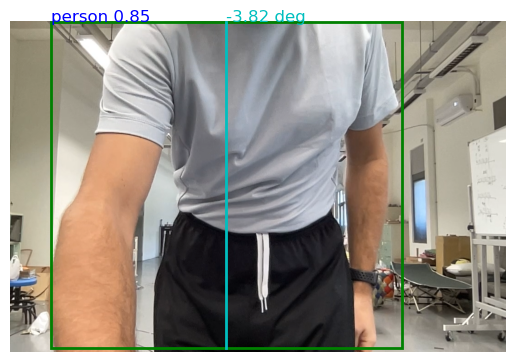

 0.27 deg


error: OpenCV(4.6.0) /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [116]:
yolo_model = YOLO('yolov8s.pt')

try:
    # Initiate the camera
    prev_angle = 0.0
    # vid = cv2.VideoCapture(0)
    vid = cv2.VideoCapture('./Movie on 2023-11-23 at 10.03.mov')
    time.sleep(0.5)

    while True:
        frame = grab_frame(vid)
        skip_frames(vid, 14)
        res = yolo_model(frame, verbose=False)
        objs = get_objs(res)

        clear_output(wait=True)

        fig, ax = plt.subplots()
        ax.imshow(frame)

        for index, obj in objs.iterrows():
            if obj['class'] != 0: continue
            if obj['score'] < 0.4: continue
            on_edge = obj['xmin'] < 10 or obj['xmax'] > wr - 10
            color = 'r' if on_edge else 'g'

            rect = patches.Rectangle((obj['xmin'], obj['ymin']), obj['xmax'] - obj['xmin'], obj['ymax'] - obj['ymin'], linewidth=2, edgecolor=color, facecolor='none')
            ax.add_patch(rect)
            text = f'{obj["name"]} {obj["score"]:.2f}'
            ax.text(obj['xmin'], obj['ymin'], text, color='b', fontsize=12)

            # draw vertical line at xcenter
            center_df = obj['xcenter']
            if on_edge:
                center_df = obj['xcenter'] // 2 if center_df < wr / 2 else (center_df + wr) // 2
            # angle_deg = (center - wr / 2) * hfov / wr
            angle_deg = pixel_angle(hfov, wr, center_df)
            ax.plot([center_df, center_df], [obj['ymin'], obj['ymax']], color='c', linewidth=2)
            ax.text(center_df, obj['ymin'], f'{angle_deg:.2f} deg', color='c', fontsize=12)

            mov_angle = angle_deg - prev_angle
            prev_angle = angle_deg

        plt.axis('off')
        plt.show()
        print(f' {mov_angle:.2f} deg')

        # save angle to csv with pandas - angle_deg and mov_angle
        # todo need to isolate one person only
        # todo add new on firts line
        pd.DataFrame({
            'a': [round(angle_deg, 2)],
            'da': [round(mov_angle, 2)]
        }).to_csv('var.csv', index=False, mode='a', header=False)
        
        # Frame rate
        # plt.pause(0.15)
        # break

except KeyboardInterrupt:
    vid.release()  # Release the camera resource

vid.release()  # Release the camera resource if break

## MediPipe Pose landmark detection

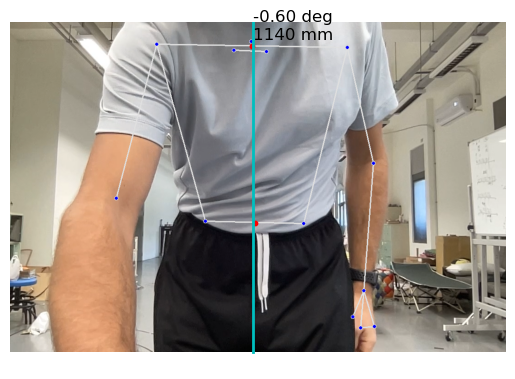

error: OpenCV(4.6.0) /private/var/folders/k1/30mswbxs7r1g6zwn8y4fyt500000gp/T/abs_11nitadzeg/croot/opencv-suite_1691620374638/work/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [111]:
def get_torso_properties(results, frame):
    left_shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_SHOULDER]
    right_shoulder = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_SHOULDER]
    left_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.LEFT_HIP]
    right_hip = results.pose_landmarks.landmark[mp_pose.PoseLandmark.RIGHT_HIP]

    left_shoulder_point = landmark_point(left_shoulder, frame.shape[1], frame.shape[0])
    right_shoulder_point = landmark_point(right_shoulder, frame.shape[1], frame.shape[0])
    left_hip_point = landmark_point(left_hip, frame.shape[1], frame.shape[0])
    right_hip_point = landmark_point(right_hip, frame.shape[1], frame.shape[0])

    shoulder_point = left_shoulder_point.middle(right_shoulder_point)
    hip_point = left_hip_point.middle(right_hip_point)
    
    torso_pixel_height = shoulder_point.distance(hip_point)
    shoulder_pixel_width = left_shoulder_point.distance(right_shoulder_point)

    return torso_pixel_height, shoulder_pixel_width, shoulder_point, hip_point


# yolo_model = YOLO('yolov8s.pt')


try:
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=False)

    # read video from file .mov file
    vid = cv2.VideoCapture('./Movie on 2023-11-23 at 10.03.mov')

    # read video from camera
    # vid = cv2.VideoCapture(1)

    distance_queue = queue.Queue(maxsize=3)

    while vid.isOpened():
        frame = grab_frame(vid)

        # skip 14 frames
        for i in range(14):
            vid.grab()

        # Frame rate
        # plt.pause(0.15)

        results = pose.process(frame)
        # objs = get_objs(yolo_model(frame, verbose=False))

        if results.pose_landmarks is not None:
            mp_drawing = mp.solutions.drawing_utils
            mp_drawing.draw_landmarks(frame, results.pose_landmarks, mp_pose.POSE_CONNECTIONS)

            torso_pixel_height, shoulder_pixel_width, shoulder_point, hip_point = get_torso_properties(results, frame)
            middle_point = shoulder_point.middle(hip_point)

            angle = pixel_angle(hfov, wr, middle_point.x)
            # distance = distance_to_camera(hfov, wr, angle, avg_shoulder_width, shoulder_pixel_width)
            distance = distance_to_camera(hfov, wr, angle, avg_torso_height, torso_pixel_height)

            angle = round(angle, 1)
            distance = int(distance // 10 * 10)

            if distance_queue.full():
                distance_queue.get()
            distance_queue.put(distance)

            sorted_queue = sorted(distance_queue.queue)
            index = round(len(sorted_queue) / 2)
            if distance_queue.full():
                # distance = np.mean(sorted_queue[index - 1:index + 1])
                distance = distance_queue.queue[index]
            else:
                distance = sorted_queue[round(len(sorted_queue) / 2)]
                distance = distance_queue.queue[-1]

            distance = int(distance // 10 * 10)

            # print(f'{distance} mm')
            # print(f'{angle} deg')

        clear_output(wait=True)
        fig, ax = plt.subplots()
        ax.imshow(frame)
        if results.pose_landmarks is not None:
            ax.scatter(shoulder_point.x, shoulder_point.y, c='r', s=10)
            ax.scatter(hip_point.x, hip_point.y, c='r', s=10)
            ax.plot([middle_point.x, middle_point.x], [0, frame.shape[0]], color='c', linewidth=2)
            ax.text(middle_point.x, 0, f'{angle:.2f} deg', color='k', fontsize=12)
            ax.text(middle_point.x, 40, f'{distance} mm', color='k', fontsize=12)
        plt.axis('off')
        plt.show()

        pd.DataFrame({
            't': [round(time.time(), 3)],
            'a': [angle],
            'd': [distance]
        }).to_csv('var.csv', index=False, mode='a', header=False)


except KeyboardInterrupt:
    vid.release()  # Release the camera resource

vid.release()  # Release the camera resource if break


## Sampled points from spline

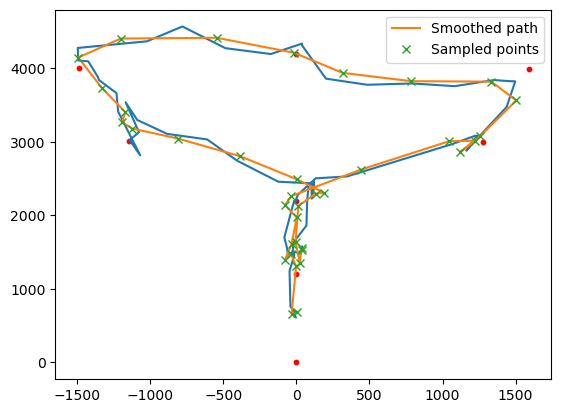

In [80]:
from scipy import interpolate
from scipy.interpolate import splrep, BSpline, splprep

# read csv
df = pd.read_csv('var_2fps.csv')
df.columns = ['t', 'a', 'd'] # time angle distance

# add column x and y
df['x'] = df['d'] * 1.15 * np.cos(np.radians(df['a']))
df['y'] = df['d'] * 1.15 * np.sin(np.radians(df['a']))



# fig, ax = plt.subplots()
# ax.plot(df['y'], df['x'])
# for p in points:
#     ax.scatter(p.y, p.x, c='r', s=10)
# plt.show()


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import LSQUnivariateSpline

# Assuming df is your DataFrame with 'x' and 'y' columns
# df = pd.read_csv('your_data.csv')  # Uncomment this line if you need to load data from a CSV file

ti = df.index

# Set the number of knots. Adjust this according to your data
# num_knots = 10
num_knots = int((ti.max() - ti.min()) // 4)
t_knots = np.linspace(ti.min(), ti.max(), num_knots)[1:-1]  # Exclude first and last points

# Fit the spline for 'x' and 'y' coordinates
spline_x = LSQUnivariateSpline(ti, df['x'], t_knots)
spline_y = LSQUnivariateSpline(ti, df['y'], t_knots)

num_samples = num_knots * 2
t_smooth = np.linspace(ti.min(), ti.max(), num_samples)

# Evaluate the spline at these points
x_sampled = spline_x(t_smooth)
y_sampled = spline_y(t_smooth)

# Create a DataFrame with the sampled data
sampled_df = pd.DataFrame({
    't': t_smooth,
    'x': x_sampled,
    'y': y_sampled
})

fig, ax = plt.subplots()
ax.plot(df['y'], df['x'])
for p in ref_points:
    ax.scatter(p.y, p.x, c='r', s=10)
ax.plot(spline_y(t_smooth), spline_x(t_smooth), label='Smoothed path')
# ax.plot(spline_y(t_smooth), spline_x(t_smooth))
ax.plot(spline_y(t_smooth), spline_x(t_smooth), 'x', label='Sampled points')
ax.legend()
plt.show()


# x = spline_x(t_smooth)
# y = spline_y(t_smooth)



# for i in range(len(x) - 4):
#     # angle between i-1 and i
#     if i == 0:
#         p1 = Point(0, 0)
#     else:
#         p1 = Point(x[i-1], y[i-1])
#     p2 = Point(x[i], y[i])

#     angle = p1.angle(p2)

#     # list of 4 points with list comprehension
#     px = [Point(x[i], y[i]) for i in range(i, i+4)]

#     # rotate 4 points by -angle around p2
#     px = [p.rotate_df(-angle, p2) for p in px]

#     clear_output(wait=True)
#     fig, ax = plt.subplots()
#     px_x = [p.x for p in px]
#     px_y = [p.y for p in px]
#     ax.plot(px_y, px_x)
    
#     ax.legend()
#     plt.show()
#     plt.pause(0.5)



## Uniformly sampled points from spline

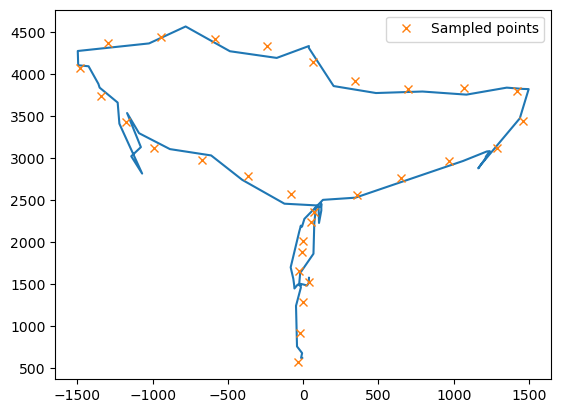

In [36]:
import numpy as np
import pandas as pd
from scipy.interpolate import LSQUnivariateSpline
import matplotlib.pyplot as plt


df = pd.read_csv('var_2fps.csv')
df.columns = ['t', 'a', 'd']
df['x'] = df['d'] * 1.15 * np.cos(np.radians(df['a']))
df['y'] = df['d'] * 1.15 * np.sin(np.radians(df['a']))

ti = np.array(df.index, dtype=float)
df['t'] = df['t'].astype(float)

# Define the spline
num_knots = int((ti.max() - ti.min()) // 4)
t_knots = np.linspace(ti.min(), ti.max(), num_knots)[1:-1]  # Exclude first and last points
spline_x = LSQUnivariateSpline(ti, df['x'], t_knots)
spline_y = LSQUnivariateSpline(ti, df['y'], t_knots)

# Initialize variables for sampling
min_distance = 350
sampled_points = []
last_point = None

# Iterate over the spline
for ti in np.linspace(ti.min(), ti.max(), 1000):  # Adjust the number of points as necessary
    current_point = Point(spline_x(ti), spline_y(ti), 0)  # Assuming z=0 as it's not in the DataFrame

    if last_point is None:
        # First point
        sampled_points.append(current_point)
        last_point = current_point
    else:
        # Check distance
        if current_point.distance(last_point) >= min_distance:
            sampled_points.append(current_point)
            last_point = current_point

# Convert sampled points to a DataFrame
sampled_df = pd.DataFrame([(p.x, p.y) for p in sampled_points], columns=['x', 'y'])


# spline_timestamp = LSQUnivariateSpline(ti, df['t'], t_knots)
# sampled_timestamps = spline_timestamp([p.t for p in sampled_points])
# sampled_df['timestamp'] = sampled_timestamps


# sampled_df['dd'] = 0
# for i in range(1, len(sampled_df['x'])):
#     p1 = Point(sampled_df['x'][i-1], sampled_df['y'][i-1], 0)
#     p2 = Point(sampled_df['x'][i], sampled_df['y'][i], 0)
#     sampled_df['dd'][i] = p1.distance(p2)


# # add column td which is the sum of the previous td and its dd
# sampled_df['td'] = 0
# for i in range(1, len(sampled_df['x'])):
#     p1 = Point(sampled_df['x'][i-1], sampled_df['y'][i-1], 0)
#     p2 = Point(sampled_df['x'][i], sampled_df['y'][i], 0)
#     sampled_df['td'][i] = sampled_df['td'][i-1] + p1.distance(p2)


# # print the whole values of sampled_df['timestamp']
# for i in range(len(sampled_df['timestamp'])):
#     print(sampled_df['timestamp'][i])


# Plot to verify
fig, ax = plt.subplots()
ax.plot(df['y'], df['x'])
ax.plot([p.y for p in sampled_points], [p.x for p in sampled_points], 'x', label='Sampled points')
# ax.plot([p.y for p in sampled_points], [p.x for p in sampled_points])
ax.legend()
plt.show()

# save to csv
# convert to int
sampled_df['x'] = sampled_df['x'].astype(int)
sampled_df['y'] = sampled_df['y'].astype(int)
# sampled_df.to_csv('sampled_positions.csv', index=False, header=False)

# sampled_df now contains the sampled data points


## Vehicule following algorithm development

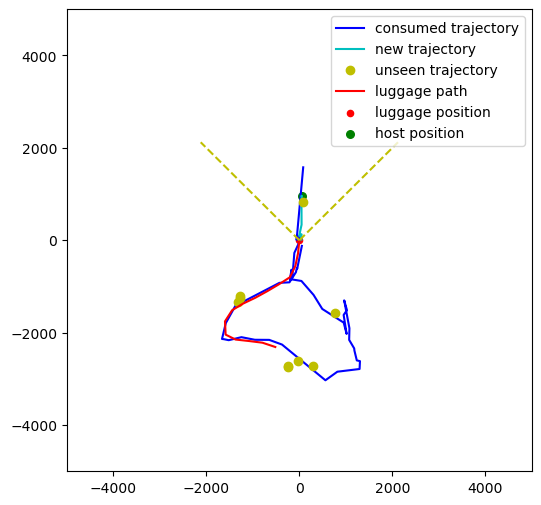

In [147]:
import pandas as pd
from scipy.interpolate import LSQUnivariateSpline
import matplotlib.pyplot as plt


# constants
marching_rate = 0.8
follow_distance = 1220
sharp_distance = 915
follow_angle = 40
hhfov = 45


# variables
position = 0
index = 0
ratio = 0.0


def move(position, marching_rate):
    position += marching_rate
    index = int(position)
    return position, index, position - index


def consume(seen_s, rotated):
    # luggage position is 0,0
    for i in range(1, len(seen_s)):
        previous = seen_s.iloc[i-1]
        current = rotated.iloc[i]
        if previous['c'] == 1 and current['x'] <= 0:
            seen_s['c'][i] = 1


def get_s_data(s_data, seen_s, l_p, angle, index):
    last_seen = seen_s.iloc[-1]
    if index >= len(s_data):
        return last_seen, 0
    
    new_pt = s_data.iloc[index]
    pt = Point.from_df(new_pt)
    pt = l_p.rotate(-angle, pt, recenter=True)
    angle = Point.origin().angle(pt)
    if abs(angle) > hhfov:
        return last_seen, angle
    return new_pt, 0


# sensor data
s_data = pd.read_csv('dist_2fps.csv', header=None)
s_data.columns = ['t', 'x', 'y']

# luggage data
l_data = pd.read_csv('sampled_positions.csv', header=None)
l_data.columns = ['x', 'y']

# luggage path
l_path = pd.DataFrame(columns=['x', 'y'])

# dataframe to store the seen points time, x, y, consumed
seen_s = pd.DataFrame(columns=['t', 'x', 'y', 'c'])
seen_s = pd.concat([seen_s, pd.DataFrame({
    't': 0,
    'x': 0,
    'y': 0,
    'c': 1
}, index=[len(seen_s)])])

unseen_s = pd.DataFrame(columns=['t', 'x', 'y'])

# image each loop is 0.5 second
for i in range(len(s_data['x']) + 5):
    clear_output(wait=True)

    # current luggage position
    l1 = Point.from_df(l_data.iloc[index])
    l2 = Point.from_df(l_data.iloc[index + 1])
    luggage = l1.between(l2, ratio)
    l_path = pd.concat([l_path, pd.DataFrame({
        'x': [luggage.x],
        'y': [luggage.y]
    }, index=[len(l_path)])])
    angle = l1.angle(l2)

    # current real human position
    human = Point.from_df(s_data.iloc[min(i, len(s_data) - 1)])

    # get sensor data
    new_pt, is_out = get_s_data(s_data, seen_s, luggage, angle, i)
    last_seen = Point.from_df(new_pt)
    seen_s = pd.concat([seen_s, pd.DataFrame({
        't': [new_pt['t']],
        'x': [new_pt['x']],
        'y': [new_pt['y']], 
        'c': 0
    }, index=[len(seen_s)])])

    if is_out:
        unseen_pt = s_data.iloc[i]
        unseen_s = pd.concat([unseen_s, pd.DataFrame({
            't': [unseen_pt['t']],
            'x': [unseen_pt['x']],
            'y': [unseen_pt['y']], 
        }, index=[len(unseen_s)])])

    # transform
    rot_unseen = luggage.rotate_df(angle, unseen_s)
    rotated = luggage.rotate_df(angle, seen_s)
    path_rot = luggage.rotate_df(angle, l_path)
    human = luggage.rotate(-angle, human, recenter=True)
    luggage = Point.origin()

    # consume trajectory
    consume(seen_s, rotated)
    rotated['c'] = seen_s['c']
    
    # plot properties
    fig, ax = plt.subplots()
    ax.set_ylim([-5000, 5000])
    ax.set_xlim([-5000, 5000])
    fig.set_figheight(6)
    fig.set_figwidth(6)

    # plot trajectory
    rot_consume = rotated[rotated['c'] == True]
    rot_not_consume = rotated[rotated['c'] == False]
    rot_not_consume = pd.concat([rot_consume.iloc[-1], rot_not_consume])

    ax.plot(rot_consume['y'], rot_consume['x'], color='b', label='consumed trajectory')
    ax.plot(rot_not_consume['y'], rot_not_consume['x'], color='c', label='new trajectory')
    ax.plot(rot_unseen['y'], rot_unseen['x'], 'o', color='y', label='unseen trajectory')

    # plot luggage position
    path_trail_len = min(35, len(path_rot))
    path_rot = path_rot.iloc[-path_trail_len:]
    ax.plot(path_rot['y'], path_rot['x'], color='r', label='luggage path')
    luggage.scatter(ax, color='r', size=20, label='luggage position')
    luggage.plot(ax, color='y', fov=hhfov*2, fov_len=3000)

    # plot human position
    human.scatter(ax, color='g', size=30, label='host position')

    ax.legend()
    plt.show()
    plt.pause(0.1)

    # move luggage to next point
    last_seen = Point.from_df(rotated.iloc[-1])
    distance = luggage.distance(last_seen)
    angle = (luggage.angle(last_seen))
    if is_out or distance > follow_distance or (distance > sharp_distance and abs(angle) > follow_angle):
        position, index, ratio = move(position, marching_rate)



## Moving Vehicule Example

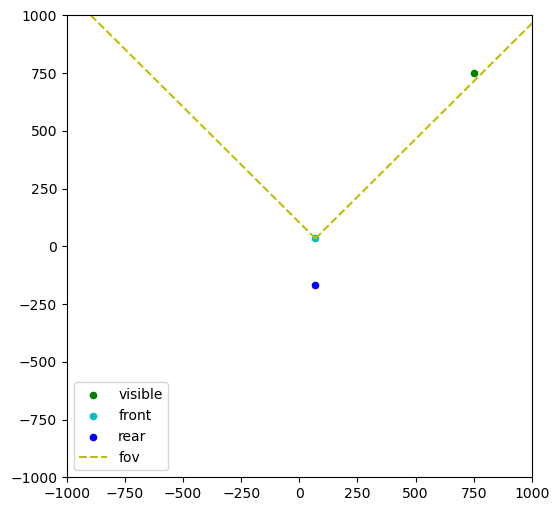

In [145]:
vehicle = Vehicle(max_turn_angle=30, axle_len=200, max_speed=2000, center=Point(0, 0))
speed, wheel_angle = 100, 0

# set_speed(speed) in mm/s
# set_wheel_angle(angle) in degrees
# update_position(time) in seconds
pt = Point(750, 750)

for i in range(42):

    if i >= 2:
        wheel_angle = 30

    if i >= 22:
        wheel_angle = -30

    vehicle.set_speed(speed)
    vehicle.set_wheel_angle(wheel_angle)
    vehicle.update_position(1)

    clear_output(wait=True)

    # plot properties
    fig, ax = plt.subplots()
    ax.set_ylim([-1000, 1000])
    ax.set_xlim([-1000, 1000])
    fig.set_figheight(6)
    fig.set_figwidth(6)

    if pt.is_seen(vehicle.get_front(), fov=vehicle.fov):
        pt.scatter(ax, color='g', size=20, label='visible')
    else:
        pt.scatter(ax, color='r', size=20, label='not visible')

    vehicle.front.scatter(ax, color='c', size=20, label='front')
    vehicle.rear.scatter(ax, color='b', size=20, label='rear')
    fov = vehicle.front.copy()
    fov.a = np.rad2deg(vehicle.north_angle)
    # black line from rear to front

    # plot line from rear to front
    fov.plot(ax, color='y', fov=90, fov_len=2000, linestyle='--', label='fov')

    ax.legend()
    plt.show()
    plt.pause(0.05)


In [ ]:
vehicle = Vehicle(max_turn_angle=30, axle_len=200, max_speed=2000, center=Point(0, 0))

# sensor data (secret)
s_data = pd.read_csv('dist_2fps.csv', header=None)
s_data.columns = ['t', 'x', 'y']

# luggage data
seen = pd.DataFrame(columns=['t', 'x', 'y', 'c'])
seen = pd.concat([seen, pd.DataFrame({
    't': 0, # timestamp
    'x': 0, # x position
    'y': 0, # y position
    'c': 1, # consumed
}, index=[len(seen)])])


for i in range(60):

    # input speed and wheel angle in one input separated by space
    speed, wheel_angle = map(int, input().split())

    vehicle.set_speed(speed)
    vehicle.set_wheel_angle(wheel_angle)
    vehicle.update_position(1)

    clear_output(wait=True)

    # plot properties
    fig, ax = plt.subplots()
    ax.set_ylim([-1000, 1000])
    ax.set_xlim([-1000, 1000])
    fig.set_figheight(6)
    fig.set_figwidth(6)

    vehicle.front.scatter(ax, color='g', size=20, label='front')
    vehicle.rear.scatter(ax, color='r', size=20, label='rear')
    fov = vehicle.front.copy()
    fov.a = vehicle.rear.angle(vehicle.front)

    # plot line from rear to front
    # ax.plot([vehicle.rear.y, vehicle.front.y], [vehicle.rear.x, vehicle.front.x], color='k')
    fov.plot(ax, color='r', fov=90, fov_len=200)

    ax.legend()
    plt.show()
    # input()
    # plt.pause(0.05)
